# NERfR (Named Entity Recognition for Recipes)

Using TASTEset, SpaCy, and recipes_scrapers

## Installations and Imports

In [1]:
%cd /home/pgajo/working/food/TASTEset

import spacy
import sys
sys.path.append('/home/pgajo/working/food/TASTEset/src')
from utils import prepare_data, ENTITIES

/storage/home/pgajo/working/food/TASTEset


/home/pgajo/working/food/food-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepping the code for spaCy

We're going to be following [the pipeline training tutorial from spaCy's documentation](https://spacy.io/usage/training). I'll give you a quick explanation if I deviate from the docs or make any calls of my own.

For formatting, we'll need  things:

1. `annotations`, which is a list of `dict`s shaped as follows:
```
{
  'text': list[str],
  'entities': list[tuple[int, int, str]]
}
```
`text` is the recipes. Here I joined them at the newline character, since that's how the authors went about it in their training script.
`entities` is just the list of entities for the recipe in `text`.
2. `classes`, which is the flat list of possible entities.

In [2]:
import json

with open('/home/pgajo/working/food/TASTEset/data/TASTEset_semicolon_en_it.json') as f:
    training_data = json.load(f)
# training_data = {
#     'classes': data['classes'],
#     'annotations': data['languages']['en'] + data['languages']['it'],
# }



FileNotFoundError: [Errno 2] No such file or directory: '/home/pgajo/working/food/TASTEset/data/TASTEset_semicolon_en_it.json'

In [ ]:
# This is taken more-or-less verbatim from the docs:
# https://spacy.io/usage/training#training-data
from spacy.tokens import DocBin

nlp_en = spacy.blank("en")
nlp_it = spacy.blank("it")

def doc_from_annotations(training_dict):

  doc_bin = DocBin()

  for example_en in training_dict['languages']['en']:
    doc_en = nlp_en.make_doc(example_en['text'].replace(';', ' '))
    print('doc_en', doc_en)
    ents_en = []
    for entity_en in example_en['entities']:
      span_en = doc_en.char_span(*entity_en, alignment_mode='strict')
      print('entity_en\t', entity_en, '\tspan_en:\t', span_en)
      print('entity_en\t', entity_en, '\traw:\t', example_en['text'][entity_en[0]:entity_en[1]])
      ents_en.append(span_en)

    doc_en.ents = ents_en
    doc_bin.add(doc_en)

  for example_it in training_dict['languages']['it']:
    doc_it = nlp_it.make_doc(example_it['text'].replace(';', ' '))
    print('doc_it', doc_it)
    ents_it = []
    for entity_it in example_it['entities']:
      print()
      span_it = doc_it.char_span(*entity_it, alignment_mode='strict')
      print('entity_it\t', entity_it, '\tspan_it:\t', span_it)
      ents_it.append(span_it)

    doc_it.ents = ents_it
    doc_bin.add(doc_it)
  return doc_bin

The train/test split is pretty project specific. I went with an 80/20 split for training/testing data. I'll say that anecdotally, it seems like the de-facto standard, and I was happy with the results.

In [ ]:
# Let's get ourselves an 80/20 split.
train_len = int(0.8*len(training_data['languages']['en'] + training_data['languages']['it']))
train_len

1120

We're saving the training data as `.spacy` files to the main directory. Feel free to move this around to fit your purposes.

In [ ]:
# sample_text = training_data['languages']['en'][0]['text']
sample_text = "5 ounces rum 4 ounces triple sec 3 ounces Tia Maria 20 ounces orange juice"
sample_entities = training_data['languages']['en'][0]['entities']
doc_en = nlp_en.make_doc(sample_text)
print(doc_en)
sample_entities_unit = sample_entities[2]
print(sample_entities_unit)
span_en = doc_en.char_span(*sample_entities_unit)
print('span_en', span_en)
print('sample_text_unit', sample_text[sample_entities_unit[0]:sample_entities_unit[1]])

5 ounces rum 4 ounces triple sec 3 ounces Tia Maria 20 ounces orange juice
[9, 12, 'FOOD']
span_en rum
sample_text_unit rum


In [30]:
train_bin = doc_from_annotations(training_data)
dev_bin = doc_from_annotations(training_data)

train_bin.to_disk("nerfr_train.spacy")
dev_bin.to_disk("nerfr_dev.spacy")

doc_en 5 ounces rum 4 ounces triple sec 3 ounces Tia Maria 20 ounces orange juice
entity_en	 [0, 1, 'QUANTITY'] 	span_en:	 5
entity_en	 [0, 1, 'QUANTITY'] 	raw:	 5
entity_en	 [2, 8, 'UNIT'] 	span_en:	 ounces
entity_en	 [2, 8, 'UNIT'] 	raw:	 ounces
entity_en	 [9, 12, 'FOOD'] 	span_en:	 rum
entity_en	 [9, 12, 'FOOD'] 	raw:	 rum
entity_en	 [13, 14, 'QUANTITY'] 	span_en:	 4
entity_en	 [13, 14, 'QUANTITY'] 	raw:	 4
entity_en	 [15, 21, 'UNIT'] 	span_en:	 ounces
entity_en	 [15, 21, 'UNIT'] 	raw:	 ounces
entity_en	 [22, 32, 'FOOD'] 	span_en:	 triple sec
entity_en	 [22, 32, 'FOOD'] 	raw:	 triple sec
entity_en	 [33, 34, 'QUANTITY'] 	span_en:	 3
entity_en	 [33, 34, 'QUANTITY'] 	raw:	 3
entity_en	 [35, 41, 'UNIT'] 	span_en:	 ounces
entity_en	 [35, 41, 'UNIT'] 	raw:	 ounces
entity_en	 [42, 51, 'FOOD'] 	span_en:	 Tia Maria
entity_en	 [42, 51, 'FOOD'] 	raw:	 Tia Maria
entity_en	 [52, 54, 'QUANTITY'] 	span_en:	 20
entity_en	 [52, 54, 'QUANTITY'] 	raw:	 20
entity_en	 [55, 61, 'UNIT'] 	span_en:	 ounces


TypeError: object of type 'NoneType' has no len()

### Training Config
Again, this is swiped from [the docs](https://spacy.io/usage/training#quickstart). The tutorial has you save the config as a text file with a `.cfg` extension. Here are the parameters I went with:

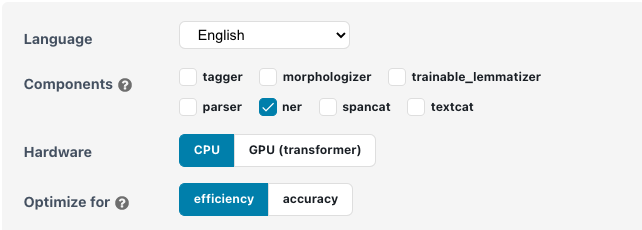

I copy/pasted the generated config below. Note that I also added the paths to the train and test datasets on lines 2 and 3. You'll want to adjust that as needed.

In [ ]:
# Transformer config
BASE_CONFIG_TRANFORMER = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = /home/pgajo/working/food/TASTEset/nerfr_train.spacy
dev = /home/pgajo/working/food/TASTEset/nerfr_dev.spacy
vectors = null
[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","ner"]
batch_size = 128

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = false
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0

[components.ner.model.tok2vec.pooling]
@layers = "reduce_mean.v1"

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 5e-5

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256

[initialize]
vectors = ${paths.vectors}"""
with open("base_config_transformer.cfg", 'w') as f:
  f.write(BASE_CONFIG_TRANFORMER)

In [ ]:
# Base config for efficiency optimization

# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
BASE_CONFIG = """
[paths]
train = nerfr_train.spacy
dev = nerfr_dev.spacy
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 96
depth = 4
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""

with open("base_config.cfg", 'w') as f:
  f.write(BASE_CONFIG)

In [ ]:
# This command fills in your config with from the base_config you generated. The
# last argument is the name of your config. I used "_eff" for "efficiency". Feel
# free to change that
!python -m spacy init fill-config /home/pgajo/working/food/TASTEset/base_config.cfg config_eff.cfg

## Training

Run the following code to train! Note that you'll have to change the path and name of the `.cfg` file as necessary. The last argument is a folder that'll contain your pipeline. Feel free to prefix it with a path to a more useful location. Also have some fun with the name!

You'll get periodic updates with the `loss`, `F1`, `precision`, `recall` for the NER model over time. They also give you a `SCORE`, which is helpful when training multiple components, but in our case, the `SCORE` is just the `F1` score for the NER model.

In [ ]:
spacy.require_gpu()

In [ ]:
!python -m spacy train /home/pgajo/working/food/TASTEset/config_eff_roberta.cfg --output output_eff_roberta -g 0

## Results

The training outputs a `meta.json` file in the output folder (`output_eff` in our case). We can use this to check a number of metrics, including the performance of each entity class.

In [ ]:
import json
import pandas as pd

# grab the performance dict from within the meta file
performance_cpu = json.load(open("/home/pgajo/working/food/TASTEset/output_eff_cpu/model-best/meta.json", 'r'))['performance']
performance_cpu_by_ent = performance_cpu['ents_per_type']

perf_df_cpu = pd.DataFrame(performance_cpu_by_ent)
perf_df_cpu["TOTAL"] = [performance_cpu['ents_p'], performance_cpu['ents_r'], performance_cpu['ents_f']]
# sort by header
perf_df_cpu = perf_df_cpu.reindex(sorted(perf_df_cpu.columns), axis=1)

# display df with the cell color corresponding to the value (dark=high; light=low)
perf_df_cpu.style.background_gradient(
    axis=1, low=perf_df_cpu.min().min(), high=1, cmap='YlOrBr'
    )

In [ ]:

# grab the performance dict from within the meta file
performance_roberta = json.load(open("/home/pgajo/working/food/TASTEset/output_transformer_0/model-best/meta.json", 'r'))['performance']
performance_roberta_by_ent = performance_roberta['ents_per_type']

perf_df_roberta = pd.DataFrame(performance_roberta_by_ent)
perf_df_roberta["TOTAL"] = [performance_roberta['ents_p'], performance_roberta['ents_r'], performance_roberta['ents_f']]
perf_df_roberta = perf_df_roberta.reindex(sorted(perf_df_roberta.columns), axis=1)

# display df with the cell color corresponding to the value (dark=high; light=low)
perf_df_roberta.style.background_gradient(
    axis=1, low=perf_df_roberta.min().min(), high=1, cmap='YlOrBr'
    )

Here we've got the precision (p), recall (r), and F1 (f) score by entity. It seems like the best performing entities are the ones we care the most about. Only 40% of *PART* entities are being turned up. I can live with that.

## Getting the Confusion Matrix

We're going to be plotting a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the same test set we used for training. At a high level, this entails running each sample through the trained model, and, for each token, storing the entity the model predicted for that token, as well as the ground truth entity (as labeled by the dataset authors).

In [ ]:
import spacy
# load the model and test set. Again, change the paths as required
nlp = spacy.load('/home/pgajo/working/food/TASTEset/output_transformer_0/model-best')
test_set = list(DocBin().from_disk("nerfr_dev.spacy").get_docs(nlp.vocab))

In [ ]:
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=ENTITIES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ENTITIES)

disp.plot()
plt.xticks(rotation=70)
plt.show()

Unfortunately, there isn't quite enough data for the color mapping to show fine-grained differences. Nonetheless, we can get a sense for the more common mislabelings.

## Inference

Let's test this baby out!

You'll notice I load the recipes as lists of ingredient lines and run each ingredient line through the pipeline separately, even though we trained the models on recipes
I found it performed better this way, despite the formatting mismatch.

In [ ]:
!pip install recipe-scrapers

In [ ]:
from recipe_scrapers import scrape_me

RECIPE_URL = "https://www.allrecipes.com/recipe/246868/pecan-sour-cream-coffee-cake/"
scraper = scrape_me(RECIPE_URL)
scraper.ingredients()

### Text Pre-Processing Function

Note the float representations of ingredient quantities, in spite of the fact that the website shows them in mixed numbers.

In [ ]:
from fractions import Fraction
import re


def fraction_to_mixed_number(fraction: Fraction) -> str:
  if fraction.numerator >= fraction.denominator:
    whole, remainder = divmod(fraction.numerator, fraction.denominator)
    if remainder == 0:
      return str(whole)
    else:
      return f"{whole} {Fraction(remainder, fraction.denominator)}"
  else:
    return str(fraction)


def convert_floats_to_fractions(text: str) -> str:
    return re.sub(
        r'\b-?\d+\.\d+\b',
        lambda match: fraction_to_mixed_number(
            Fraction(float(match.group())).limit_denominator()), text
        )


def process_text(text, model=nlp):
  """
  A wrapper function to pre-process text and run it through our pipeline.
  """
  return nlp(convert_floats_to_fractions(text))

In [ ]:
# Let's have a look at our processing fucntion at work
[convert_floats_to_fractions(line) for line in scraper.ingredients()]

### Running Inference with Processing

In [ ]:
import spacy

In [ ]:
# Load the model again for good measure
nlp_cpu = spacy.load('/home/pgajo/working/food/TASTEset/output_eff_cpu/model-best')
nlp_roberta = spacy.load('/home/pgajo/working/food/TASTEset/output_transformer_0/model-best')

from spacy import displacy

In [ ]:
# process the recipe, line-by-line
docs_cpu = [process_text(line, model = nlp_cpu) for line in scraper.ingredients()]

displacy.render(docs_cpu, style="ent", jupyter=True)

In [ ]:
docs_roberta = [process_text(line, model = nlp_roberta) for line in scraper.ingredients()]

displacy.render(docs_roberta, style="ent", jupyter=True)

In [ ]:
PREPPY_URL = 'https://preppykitchen.com/coffee-cake/'
scraper = scrape_me(PREPPY_URL, wild_mode=True)
scraper.ingredients()

In [ ]:
# process the recipe, line-by-line
docs_roberta = [process_text(line) for line in scraper.ingredients()]

displacy.render(docs_roberta, style="ent", jupyter=True)

And that's all folks! Feel free to use this code for your own purposes, and happy parsing!